# Projet CSAA - Classification du rythme cardiaque issu d'ECG


Ce jeu de données est composé d'une collections de signaux de battements cardiaques provenant d'un jeu de données célèbres dans le domaine de la classification des battements cardiaques, le jeu de données sur l'arythmie du MIT-BIH.

Les signaux correspondent à des formes d'électrocardiogramme (ECG) de battements cardiaques pour le cas normal et les cas affectés par différentes arythmies et infarctus du myocarde. Ces signaux sont prétraités et segmentés, chaque segment correspondant à un battement cardiaque.

<img src="./DataECG.png" width="800" height="600">

On distingue 5 battements cardiaques différents : Battements normaux', 'Battements inconnus', 'Battements ectopiques ventriculaires', 'Battements ectopiques supraventriculaires' et 'Battements de fusion'.

De ces signaux, on extrait des caractéristiques par la librairie TSFEL - *Time Series Features Extraction Library* (https://tsfel.readthedocs.io/en/latest/index.html)

Les 156 caractéristiques extraites sont divisées selon les domaines :
- temporel avec 31 caractéristiques comme l'entropie, Max, Min, Absolute Energy ...
- statistique avec 14 caractéristiques comme écart moyen absolu, écart médian, variance, Kurtosis...
- spectral  avec 111 caractéristiques comme les coefficients FFT par bande de fréquence, ondelettes...

Lien vers le papier expliquant TSFEL : https://www.sciencedirect.com/science/article/pii/S2352711020300017

In [1]:
# Librairies utiles
import numpy as np
import sklearn
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Chargement des données d'apprentissage et de test

In [2]:
# Chargement des données brutes 
DataECGFull=np.load('./DataECG.npy')
print('Taille du dataset ECG:', DataECGFull.shape)

# Après extraction des features
# Chargement des données d'apprentissage
DataFeature=np.load('./DataFeature.npy')
Label=np.load('./Label.npy')
print('Taille du dataset après extraction de features :', DataFeature.shape, Label.shape)


# Séparation en ensemble d'apprentissage et de test 
from sklearn.model_selection import train_test_split

DataECGApp, DataECGTest, Label_train, Label_test = train_test_split(DataECGFull, Label, test_size=0.2, random_state=42)
DataFeatureApp, DataFeatureTest, LabelF_train, LabelF_test = train_test_split(DataFeature, Label, test_size=0.2, random_state=42)

print('Taille de la base d apprentissage ECG :', DataECGApp.shape, 'Taille du dataset de test ECG :', DataECGTest.shape)
print('Taille de la base d apprentissage Features :', DataFeatureApp.shape, 'Taille du dataset de test Features :', DataFeatureApp.shape)


Taille du dataset ECG: (5000, 188)
Taille du dataset après extraction de features : (5000, 156) (5000,)
Taille de la base d apprentissage ECG : (4000, 188) Taille du dataset de test ECG : (1000, 188)
Taille de la base d apprentissage Features : (4000, 156) Taille du dataset de test Features : (4000, 156)


In [3]:
label_name = ["battement normaux", "battement inconnus"," bat ect. ventriculaire", "bat. ect. supra", "battement de fusion"]

## Vecteur médian des caractéristiques pour chaque classe

In [4]:
# Calculer le vecteur médian des caractéristiques pour chaque classe
class_feature_medians = {}

# Trouver les labels uniques avec numpy
unique_labels = np.unique(LabelF_train)
print("Classes uniques :", unique_labels)

for label in unique_labels:
  Data_App_Temp= DataFeatureApp[:,:32]
  # Filtrer les données pour la classe actuelle
  class_features = Data_App_Temp[np.array(LabelF_train) == label]
    # Calculer la médiane des caractéristiques pour cette classe
  class_median = np.median(class_features, axis=0)  # Utilisation de np.median()
  class_feature_medians[label] = class_median

Classes uniques : [0. 1. 2. 3. 4.]


# Chargement des variables issues *TSFEL*

In [5]:
ListeVariablesStat=np.load('./ListeVariableStat.npy',allow_pickle=True)
print('Nombre de variables statistiques :',ListeVariablesStat.shape)
#print('Liste Variables Statistiques :', ListeVariablesStat)

ListeVariablesTemps=np.load('./ListeVariableTemps.npy',allow_pickle=True)
print('Nombre de variables temporelles :',ListeVariablesTemps.shape)
#print('Liste Variables Temporelles :',ListeVariablesTemps)

ListeVariablesSpectral=np.load('./ListeVariableSpectral.npy',allow_pickle=True)
print('Nombre de variables spectrales :',ListeVariablesSpectral.shape)
#print('Liste Variables Spectrales :',ListeVariablesSpectral)

Nombre de variables statistiques : (31,)
Nombre de variables temporelles : (14,)
Nombre de variables spectrales : (111,)


### Fonctions pour réaliser une table de correspondance entre le label des approches non supervisées et le label réel

In [6]:
def retrieve_info(cluster_labels,y_train):
 #Associe l'étiquette la plus probable à chaque groupe dans le modèle KMeans.
 #Résultats : dictionnaire des clusters associés à chaque étiquette.

# Initialisation
  reference_labels = np.zeros((len(np.unique(cluster_labels)),1))
# Loop pour chaque label
  for i in range(len(np.unique(cluster_labels))):
    index = np.where(cluster_labels == i,1,0)
    num = np.bincount(y_train[index==1]).argmax()
    reference_labels[i] = num
  return reference_labels

def correspondance(y_pred_kmeans,y_train):
  # Correspondance entre la partition et les classes de la vérité terrain
  reference_labels = retrieve_info(y_pred_kmeans,y_train)
  number_labels = np.zeros(len(y_pred_kmeans))
  for i in range(len(y_pred_kmeans)):
    number_labels[i] = reference_labels[y_pred_kmeans[i]]
  return number_labels


# Partie I : Implémentation de l'algorithme de programmation dynamique (DTW)

1. Ecrivez une fonction en python DTW qui implémente le calcul et l'affichage de la matrice des coûts définie en TD. 



In [27]:
from math import *
import numpy as np
import sys

In [28]:
from sklearn.preprocessing import StandardScaler

# Normalisation des données d'apprentissage et de test
scaler = StandardScaler()
DataFeatureApp_normalized = scaler.fit_transform(DataFeatureApp)
DataFeatureTest_normalized = scaler.transform(DataFeatureTest)

In [29]:
# Calculer les vecteurs médians des caractéristiques pour chaque classe
class_feature_medians = {}

# Trouver les labels uniques
unique_labels = np.unique(LabelF_train)

for label in unique_labels:
    # Filtrer les données pour la classe actuelle
    class_features = DataFeatureApp_normalized[np.array(LabelF_train) == label]
    
    # Calculer la médiane des caractéristiques pour cette classe
    class_median = np.median(class_features, axis=0)
    class_feature_medians[label] = class_median

# Afficher les vecteurs médians pour chaque classe
for label, median in class_feature_medians.items():
    print(f"Classe {label} : Médiane calculée avec {len(median)} caractéristiques")

Classe 0.0 : Médiane calculée avec 156 caractéristiques
Classe 1.0 : Médiane calculée avec 156 caractéristiques
Classe 2.0 : Médiane calculée avec 156 caractéristiques
Classe 3.0 : Médiane calculée avec 156 caractéristiques
Classe 4.0 : Médiane calculée avec 156 caractéristiques


In [30]:
def DTW(A, B, d, w0=1, w1=1, w2=1):
    """
    Algorithme DTW avec poids ajustables pour aligner deux séries temporelles.

    Args:
        A (list or np.ndarray): Première série temporelle.
        B (list or np.ndarray): Deuxième série temporelle.
        d (function): Fonction de distance locale entre deux points.
        w0 (int): Poids pour l'insertion.
        w1 (int): Poids pour la correspondance.
        w2 (int): Poids pour la suppression.

    Returns:
        float: Score d'alignement.
        list: Chemin optimal d'alignement.
    """
    N, M = len(A), len(B)
    g = np.full((N + 1, M + 1), float('inf'))
    g[0, 0] = 0

    for i in range(1, N + 1):
        for j in range(1, M + 1):
            cost = d(A[i - 1], B[j - 1])
            g[i, j] = min(
                g[i - 1, j] + w0 * cost,
                g[i - 1, j - 1] + w1 * cost,
                g[i, j - 1] + w2 * cost
            )

    S = g[N, M] / (N + M)
    path = []
    i, j = N, M
    while i > 0 or j > 0:
        path.append((i - 1, j - 1))
        if i > 0 and j > 0 and g[i, j] == g[i - 1, j - 1] + w1 * d(A[i - 1], B[j - 1]):
            i -= 1
            j -= 1
        elif i > 0 and g[i, j] == g[i - 1, j] + w0 * d(A[i - 1], B[j - 1]):
            i -= 1
        else:
            j -= 1

    path.reverse()
    return S, path

(0.5714285714285714, [(3, 2), (2, 2), (1, 2), (1, 1), (0, 0)])

Pour chaque battement du jeu de test, calculez la distance DTW entre les caractéristiques extraites et les profils médianes de chaque classe.

## Système de reconnaissance de battements cardiaques par DTW



**Système de reconnaissance :**
Pour chaque profil temporel test :

a) Calculer pour chaque classe, le score de la DTW entre le profil temporel test et les profils temporels de la classe 

b) Déterminer la classe d'appartenance par minimum du score sur toutes les classes


In [31]:
TAILLE_TEST = DataECGTest.shape[0]  # Nombre d'exemples de test
N_CLASSES = 5  

In [33]:
TAILLE_TEST

1000

In [34]:
def euclidean_distance(x, y):
    return np.sqrt(np.sum((x - y) ** 2))

def manhattan_distance(x, y):
    return np.sum(np.abs(x - y))

In [35]:
# Initialiser la partition avec deux colonnes : classe réelle et classe prédite
PartitionDTW = np.zeros((TAILLE_TEST, 2))

# Appliquer DTW pour chaque vecteur de test
for i, test_vector in enumerate(DataFeatureTest_normalized):
    best_score = float('inf')  # Initialiser le meilleur score à l'infini
    best_label = None  # Label correspondant au meilleur score

    for label, class_median in class_feature_medians.items():
        # Calcul du score DTW entre le vecteur de test et le vecteur médian de la classe
        score, _ = DTW(test_vector, class_median, euclidean_distance)

        # Vérifier si c'est le meilleur score
        if score < best_score:
            best_score = score
            best_label = label

    # Enregistrer la classe réelle et prédite dans PartitionDTW
    PartitionDTW[i, 0] = LabelF_test[i]  # Classe réelle
    PartitionDTW[i, 1] = best_label  # Classe prédite

    # Afficher le score et la classe prédite pour l'instance actuelle
    print(f"Vecteur de test {i + 1} : Meilleur score = {best_score:.4f}, Classe prédite = {best_label}")

Vecteur de test 1 : Meilleur score = 0.2435, Classe prédite = 1.0
Vecteur de test 2 : Meilleur score = 0.4216, Classe prédite = 4.0
Vecteur de test 3 : Meilleur score = 0.3558, Classe prédite = 2.0
Vecteur de test 4 : Meilleur score = 0.2207, Classe prédite = 4.0
Vecteur de test 5 : Meilleur score = 0.2645, Classe prédite = 1.0
Vecteur de test 6 : Meilleur score = 0.1937, Classe prédite = 2.0
Vecteur de test 7 : Meilleur score = 0.1872, Classe prédite = 0.0
Vecteur de test 8 : Meilleur score = 0.3351, Classe prédite = 4.0
Vecteur de test 9 : Meilleur score = 0.1039, Classe prédite = 2.0
Vecteur de test 10 : Meilleur score = 0.2587, Classe prédite = 1.0
Vecteur de test 11 : Meilleur score = 0.1907, Classe prédite = 2.0
Vecteur de test 12 : Meilleur score = 0.1738, Classe prédite = 1.0
Vecteur de test 13 : Meilleur score = 0.2069, Classe prédite = 3.0
Vecteur de test 14 : Meilleur score = 0.1970, Classe prédite = 4.0
Vecteur de test 15 : Meilleur score = 0.0652, Classe prédite = 3.0
Vect

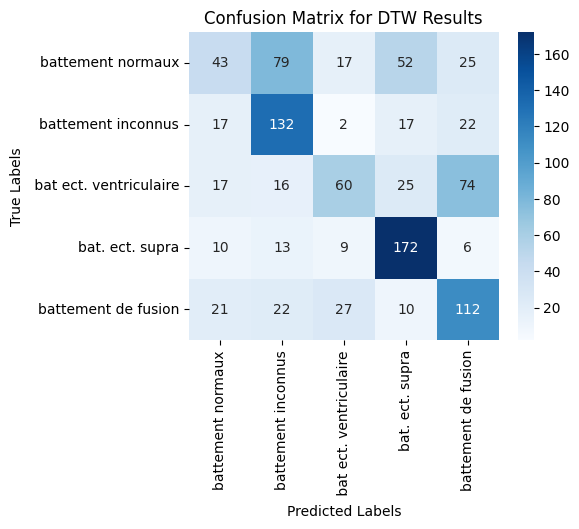

Accuracy du modèle DTW: 0.52
                         precision    recall  f1-score   support

      battement normaux       0.40      0.20      0.27       216
     battement inconnus       0.50      0.69      0.58       190
 bat ect. ventriculaire       0.52      0.31      0.39       192
        bat. ect. supra       0.62      0.82      0.71       210
    battement de fusion       0.47      0.58      0.52       192

               accuracy                           0.52      1000
              macro avg       0.50      0.52      0.49      1000
           weighted avg       0.50      0.52      0.49      1000



In [36]:
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report

# Calcul de la matrice de confusion
cm = confusion_matrix(PartitionDTW[:, 0], PartitionDTW[:, 1])

# Affichage de la matrice de confusion
plt.figure(figsize=(5, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=label_name, yticklabels=label_name)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix for DTW Results')
plt.show()

# Calcul de l'accuracy
accuracy = accuracy_score(PartitionDTW[:, 0], PartitionDTW[:, 1])
print(f"Accuracy du modèle DTW: {accuracy:.2f}")

# Rapport de classification
print(classification_report(PartitionDTW[:, 0], PartitionDTW[:, 1], target_names=label_name))

**Evaluation :** A partir de la partition de l'ensemble test obtenue après la DTW, calculer la matrice de confusion qui recense le nombre de données bien classés et mal classés.

# Partie II : Classification des battements cardiaques sur les features sans prétraitement

Réaliser une classification des battements cardiaques par une méthode d'apprentissage supervisé et une méthode d'apprentissage non supervisé de votre choix en utilisant la librairie *scikit-learn*.

Pour chaque résultat obtenu, calculer la matrice de confusion et interpréter les résultats.


## Méthodes supervisées  :
indiquer quelles sont les 2 méthodes supervisées de votre choix et calculer la matrice de confusion associée.

#### Méthode supervisée 1 : Random Forest

In [7]:
from sklearn.ensemble import RandomForestClassifier
rf_clf = RandomForestClassifier(n_estimators=100, random_state=42)
rf_clf.fit(DataFeatureApp, LabelF_train)
pred_rf = rf_clf.predict(DataFeatureTest)

#### Méthode supervisée 2 : Gradient Boosting

In [8]:
from sklearn.ensemble import GradientBoostingClassifier
gb_clf = GradientBoostingClassifier(n_estimators=10, learning_rate=0.1, random_state=42)
gb_clf.fit(DataFeatureApp, LabelF_train)
pred_gb = gb_clf.predict(DataFeatureTest)

#### Méthode supervisée 3 : K-Nearest Neighbors (KNN)

In [9]:
from sklearn.neighbors import KNeighborsClassifier
knn_clf = KNeighborsClassifier(n_neighbors=5)
knn_clf.fit(DataFeatureApp, LabelF_train)
pred_knn = knn_clf.predict(DataFeatureTest)

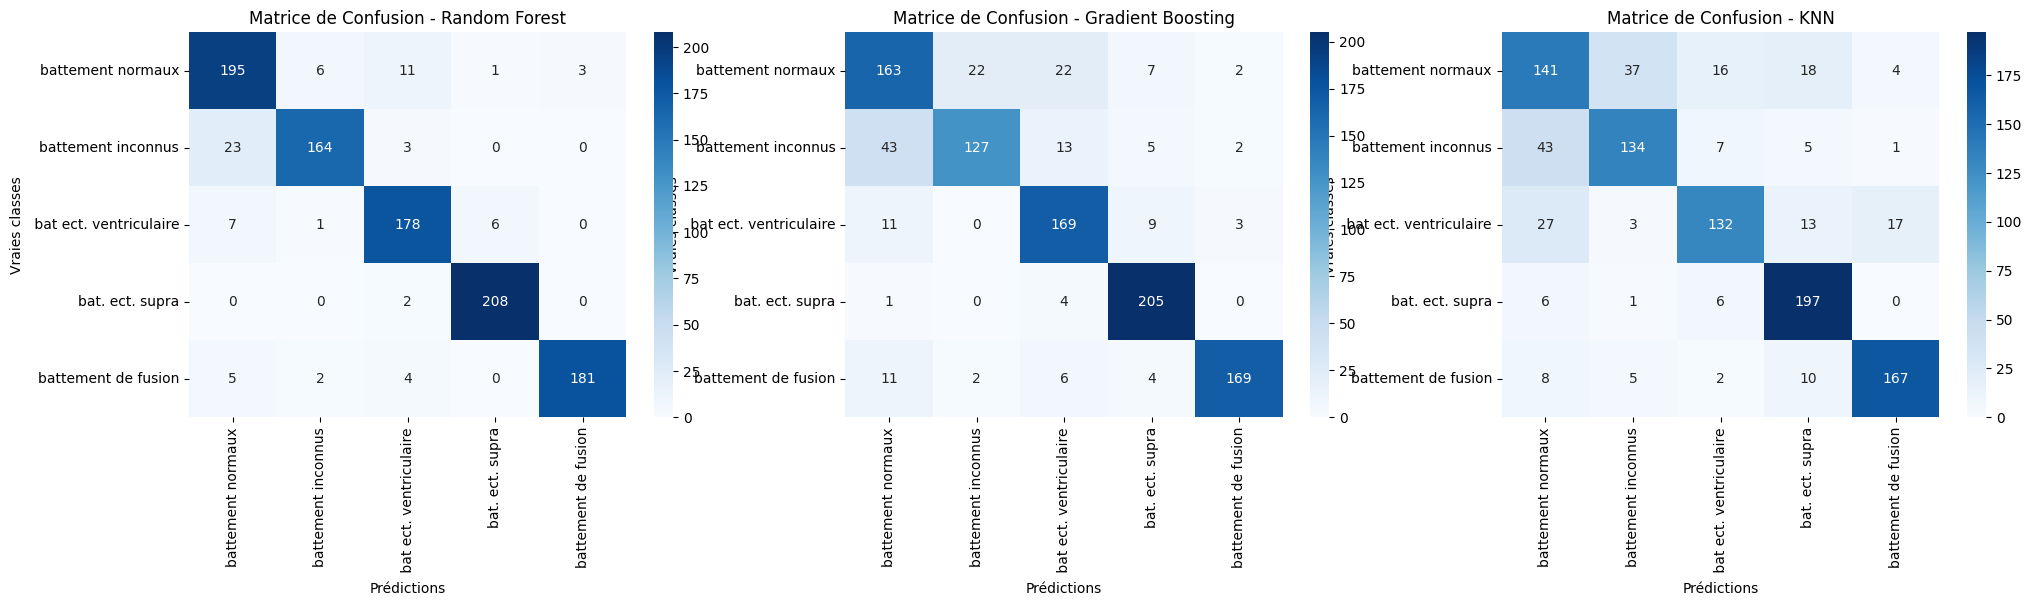

In [10]:
from sklearn.metrics import confusion_matrix

# Génération et affichage des matrices de confusion
fig, axes = plt.subplots(1, 3, figsize=(24, 5))
for ax, pred, title in zip(axes, [pred_rf, pred_gb, pred_knn], ["Random Forest", "Gradient Boosting", "KNN"]):
    cm = confusion_matrix(LabelF_test, pred)
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=label_name, yticklabels=label_name, ax=ax)
    ax.set_title(f"Matrice de Confusion - {title}")
    ax.set_xlabel("Prédictions")
    ax.set_ylabel("Vraies classes")
plt.show()


## Méthodes non supervisées

Indiquer quelles sont les 2 méthodes non supervisées de votre choix et calculer la matrice de confusion associée.

#### Méthode non supervisée 1 : K-Means

In [11]:
from sklearn.cluster import KMeans

# Initialiser le modèle KMeans
kmeans = KMeans(n_clusters=5, random_state=42)

# Ajuster le modèle sur les données d'apprentissage
kmeans.fit(DataFeatureApp)

# Prédire les clusters pour les données de test
y_pred_kmeans = kmeans.predict(DataFeatureTest)


c:\Users\user\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


#### Méthode non supérvisé 2:  1_NN

In [29]:
#methode non supervisée pour la classification des battements cardiaques
#hors kmeans 1_nn
from sklearn.neighbors import KNeighborsClassifier
Onenn = KNeighborsClassifier(n_neighbors=1)
Onenn.fit(DataFeatureApp, LabelF_train)
y_pred_Onenn = Onenn.predict(DataFeatureTest)


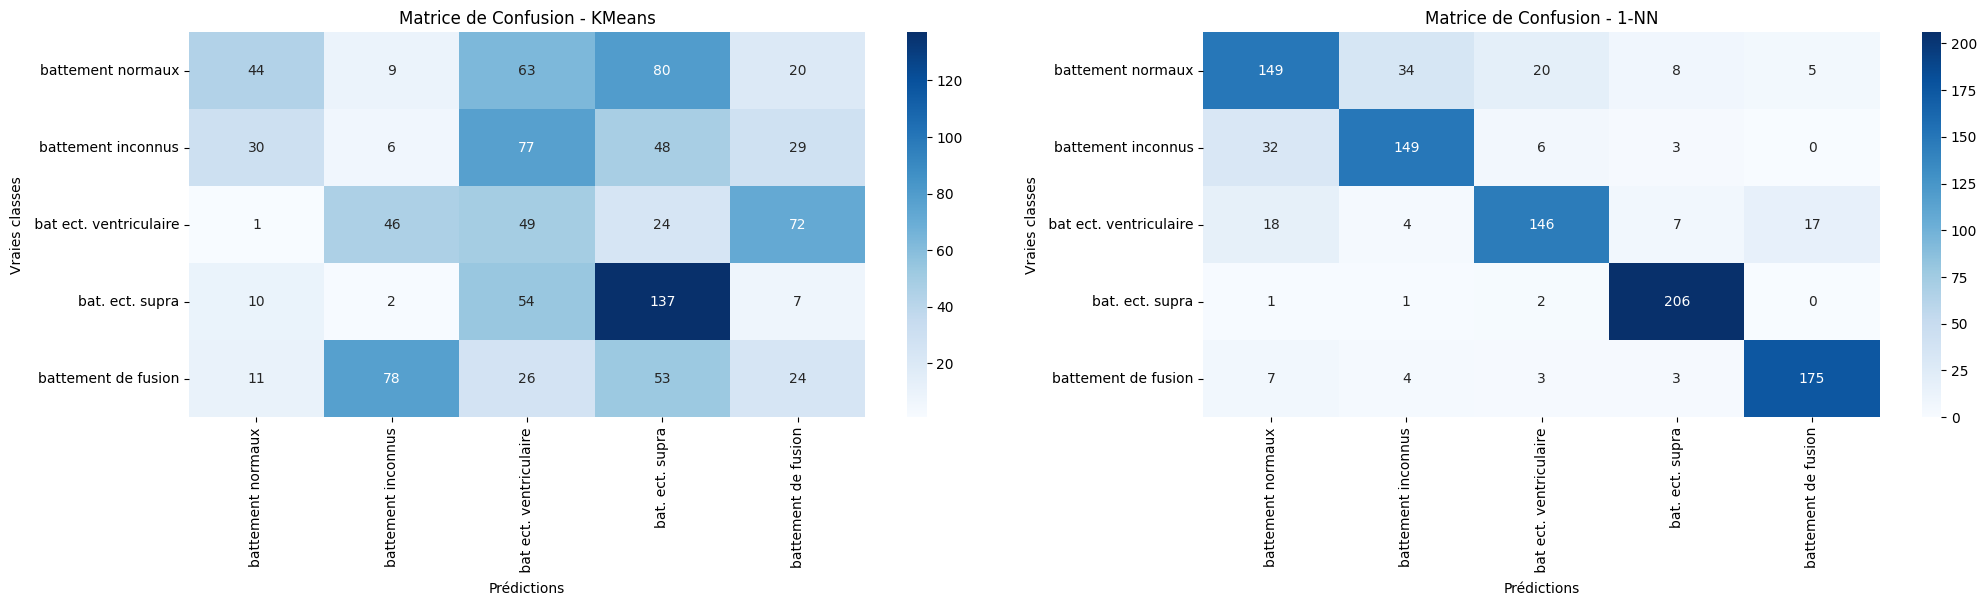

In [34]:
# Génération et affichage des matrices de confusion
fig, axes = plt.subplots(1, 2, figsize=(24, 5))
for ax, pred, title in zip(axes, [y_pred_kmeans, y_pred_Onenn], ["KMeans", "1-NN"]):
    cm = confusion_matrix(LabelF_test, pred)
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=label_name, yticklabels=label_name, ax=ax)
    ax.set_title(f"Matrice de Confusion - {title}")
    ax.set_xlabel("Prédictions")
    ax.set_ylabel("Vraies classes")

# Partie III : classification des battements cardiaques sur les features avec prétraitement par ACP

## Méthode supervisée avec réduction de dimension par ACP sur l'ensemble d'apprentissage
Réaliser une ACP sur l'ensemble d'apprentissage pour réduire la dimension, visualiser les données
puis projeter les données de l'ensemble de test dans la base de l'ACP.

Indiquer quelles sont les 2 méthodes supervisées de votre choix et calculer la matrice de confusion associée (confusion_matrix) et le score de performance (accuracy_score)

In [12]:
from sklearn.decomposition import PCA

### Classification après réduction de dimension par ACP

In [24]:
# Définition des niveaux de variance expliquée
variance_levels = [0.95, 0.90, 0.85]

In [25]:
from sklearn.preprocessing import StandardScaler

# Normalisation des données
scaler = StandardScaler()
DataFeatureApp_normalized = scaler.fit_transform(DataFeatureApp)
DataFeatureTest_normalized = scaler.transform(DataFeatureTest)

##    Modèles supervisés

In [26]:
# Modèles supervisés à tester
models = {
    "Random Forest": RandomForestClassifier(n_estimators=100, random_state=42),
    "Gradient Boosting": GradientBoostingClassifier(n_estimators=10, learning_rate=0.1, random_state=42),
    "KNN": KNeighborsClassifier(n_neighbors=5)
}


--- ACP avec 95.0% de variance expliquée ---
Nombre de composantes après ACP : 36
Random Forest - Score de précision : 0.9090
Gradient Boosting - Score de précision : 0.8010
KNN - Score de précision : 0.8880


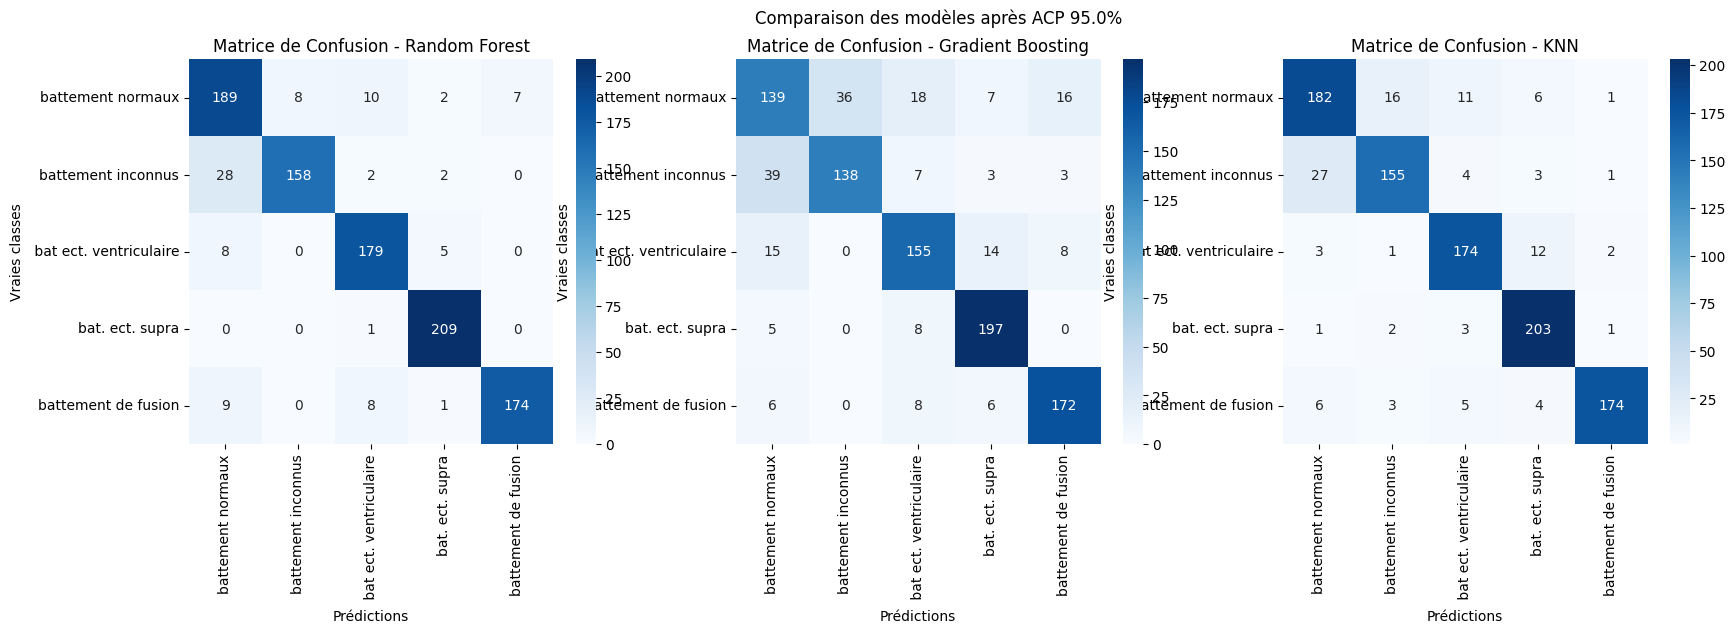


--- ACP avec 90.0% de variance expliquée ---
Nombre de composantes après ACP : 23
Random Forest - Score de précision : 0.9090
Gradient Boosting - Score de précision : 0.8030
KNN - Score de précision : 0.8890


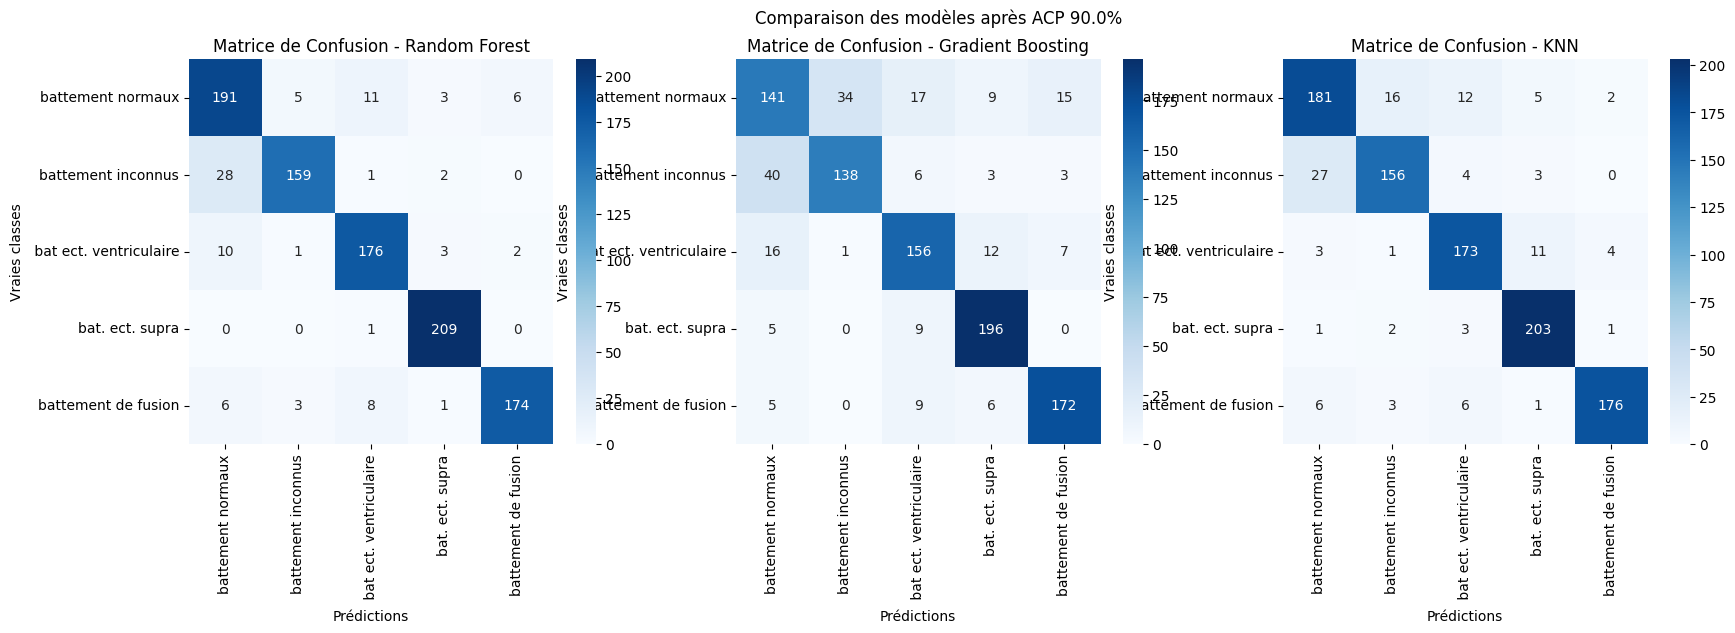


--- ACP avec 85.0% de variance expliquée ---
Nombre de composantes après ACP : 15
Random Forest - Score de précision : 0.9050
Gradient Boosting - Score de précision : 0.7800
KNN - Score de précision : 0.8880


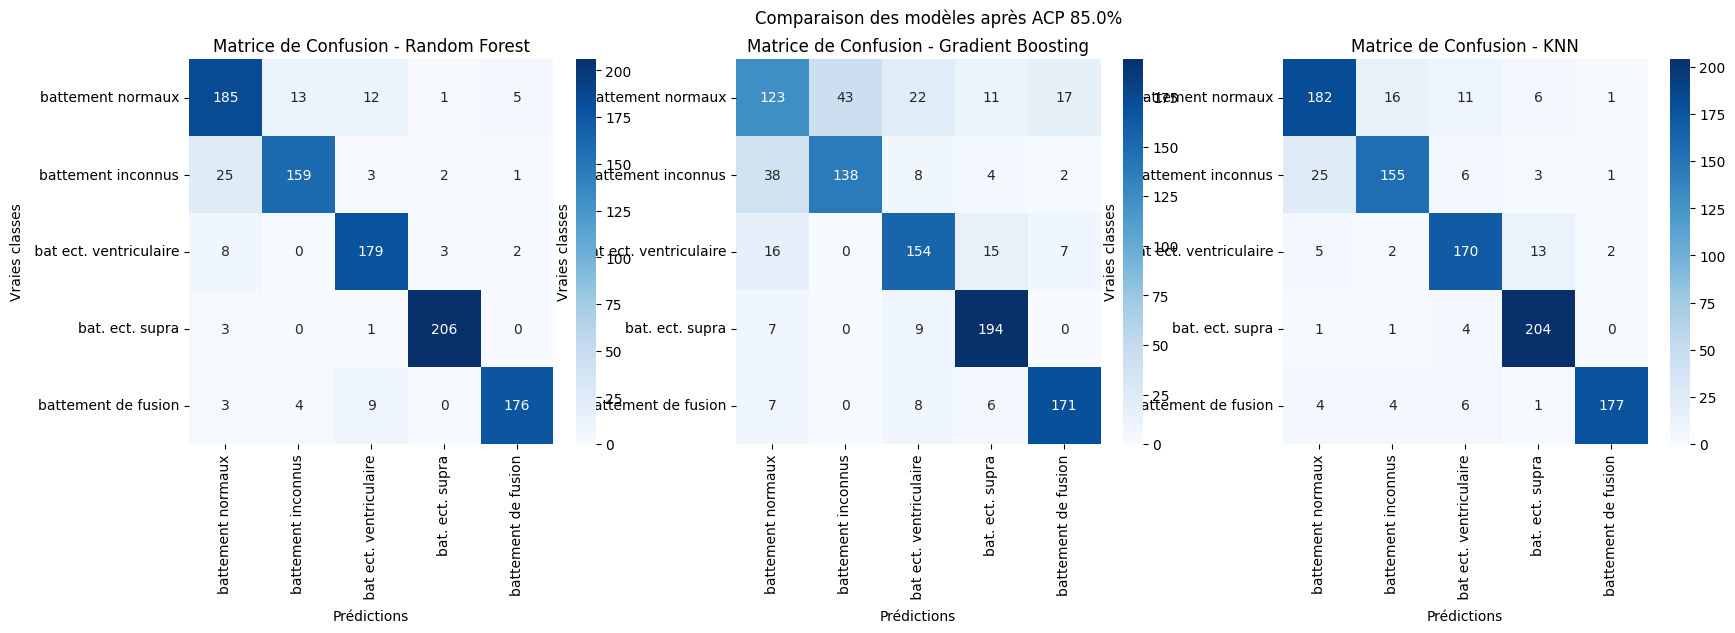


--- Résumé des scores de précision ---
Random Forest - ACP 95.0% : 0.9090
Random Forest - ACP 90.0% : 0.9090
Random Forest - ACP 85.0% : 0.9050
Gradient Boosting - ACP 95.0% : 0.8010
Gradient Boosting - ACP 90.0% : 0.8030
Gradient Boosting - ACP 85.0% : 0.7800
KNN - ACP 95.0% : 0.8880
KNN - ACP 90.0% : 0.8890
KNN - ACP 85.0% : 0.8880


In [27]:
# Stocker les scores pour chaque modèle et chaque niveau d'ACP
scores = {model_name: [] for model_name in models.keys()}

# Boucle sur chaque niveau d'ACP
for variance in variance_levels:
    print(f"\n--- ACP avec {variance * 100}% de variance expliquée ---")
    
    # Appliquer l'ACP
    pca = PCA(n_components=variance)
    DataFeatureApp_pca = pca.fit_transform(DataFeatureApp_normalized)
    DataFeatureTest_pca = pca.transform(DataFeatureTest_normalized)

    print(f"Nombre de composantes après ACP : {pca.n_components_}")

    # Créer une figure pour afficher les matrices de confusion des 3 modèles côte à côte
    fig, axes = plt.subplots(1, 3, figsize=(20, 5))

    # Boucle sur chaque modèle
    for idx, (model_name, model) in enumerate(models.items()):
        # Entraînement du modèle
        model.fit(DataFeatureApp_pca, LabelF_train)
        pred = model.predict(DataFeatureTest_pca)

        # Calculer la matrice de confusion et le score de précision
        cm = confusion_matrix(LabelF_test, pred)
        acc = accuracy_score(LabelF_test, pred)
        scores[model_name].append(acc)  # Stocker le score

        # Affichage de la matrice de confusion
        sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=label_name, yticklabels=label_name, ax=axes[idx])
        axes[idx].set_title(f"Matrice de Confusion - {model_name}")
        axes[idx].set_xlabel("Prédictions")
        axes[idx].set_ylabel("Vraies classes")

        print(f"{model_name} - Score de précision : {acc:.4f}")

    plt.suptitle(f"Comparaison des modèles après ACP {variance * 100}%")
    plt.show()

# Afficher les résultats finaux
print("\n--- Résumé des scores de précision ---")
for model_name, acc_list in scores.items():
    for idx, variance in enumerate(variance_levels):
        print(f"{model_name} - ACP {variance * 100}% : {acc_list[idx]:.4f}")


## Méthode non supervisée avec réduction de dimension par ACP sur l'ensemble des données

Réaliser une ACP sur l'ensemble des données et indiquer quelles sont les méthodes non supervisées de votre choix et calculer la matrice de confusion associée (confusion_matrix) et le score de performance (accuracy_score)

In [28]:
from sklearn.neighbors import NearestNeighbors

# Modèles non supervisés
models = {
    "KNN (K=1)": NearestNeighbors(n_neighbors=1),
    "K-Means": KMeans(n_clusters=len(np.unique(LabelF_train)), n_init=10, random_state=42)
}



--- ACP avec 95.0% de variance expliquée ---
Nombre de composantes après ACP : 36
KNN (K=1) - Score d'ajustement : 0.9180
K-Means - Score d'ajustement : 0.5170


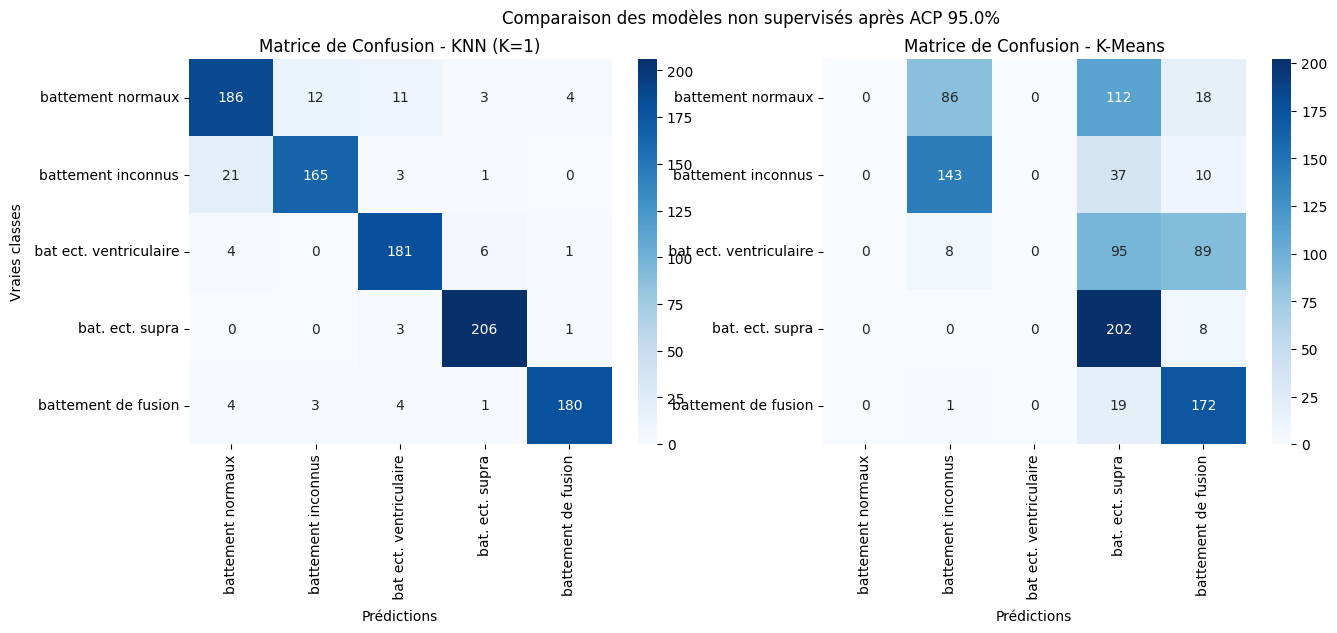


--- ACP avec 90.0% de variance expliquée ---
Nombre de composantes après ACP : 23
KNN (K=1) - Score d'ajustement : 0.9080
K-Means - Score d'ajustement : 0.5170


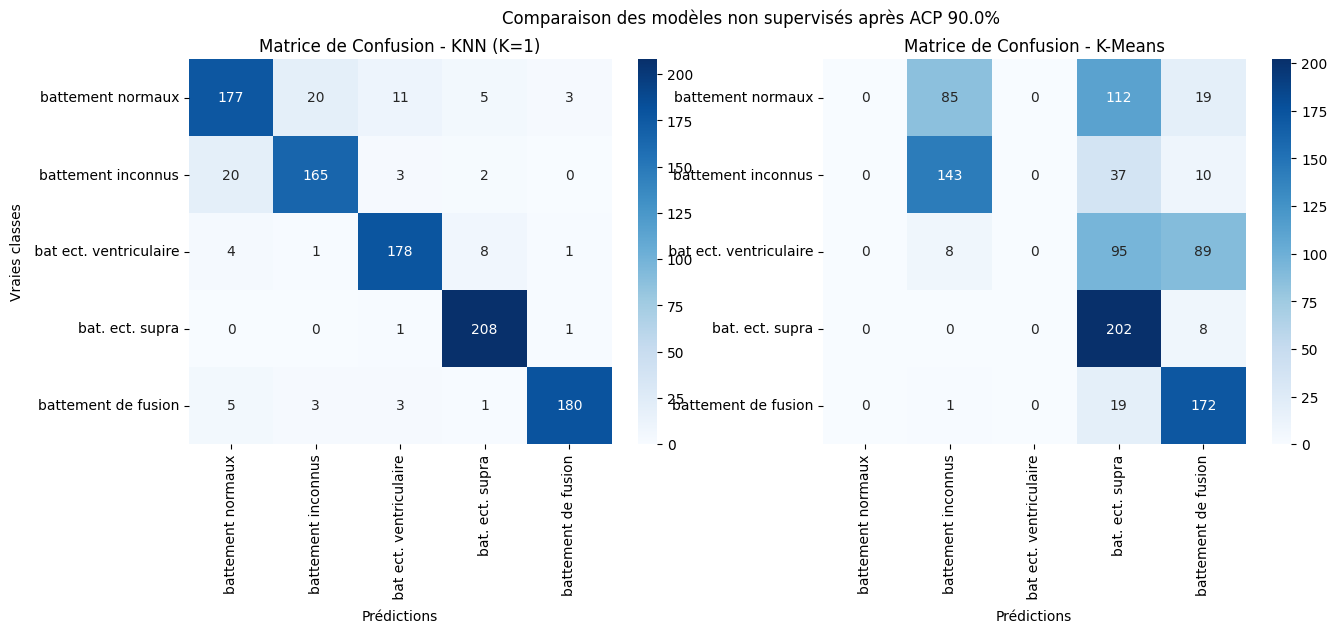


--- ACP avec 85.0% de variance expliquée ---
Nombre de composantes après ACP : 15
KNN (K=1) - Score d'ajustement : 0.9000
K-Means - Score d'ajustement : 0.5170


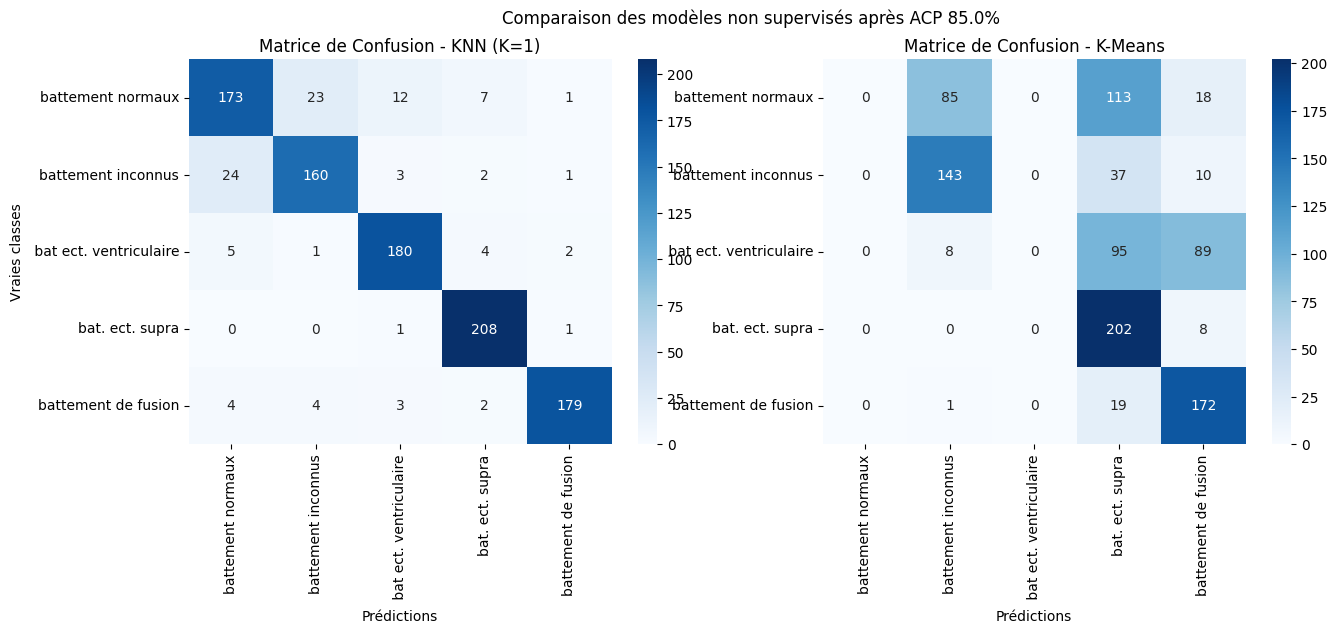


--- Résumé des scores d'ajustement ---
KNN (K=1) - ACP 95.0% : 0.9180
KNN (K=1) - ACP 90.0% : 0.9080
KNN (K=1) - ACP 85.0% : 0.9000
K-Means - ACP 95.0% : 0.5170
K-Means - ACP 90.0% : 0.5170
K-Means - ACP 85.0% : 0.5170


In [31]:
from collections import Counter

# Stocker les scores pour chaque modèle et chaque niveau d'ACP
scores2 = {model_name: [] for model_name in models.keys()}

# Boucle sur chaque niveau d'ACP
for variance in variance_levels:
    print(f"\n--- ACP avec {variance * 100}% de variance expliquée ---")
    
    # Appliquer l'ACP
    pca = PCA(n_components=variance)
    DataFeatureApp_pca = pca.fit_transform(DataFeatureApp_normalized)
    DataFeatureTest_pca = pca.transform(DataFeatureTest_normalized)

    print(f"Nombre de composantes après ACP : {pca.n_components_}")

    # Créer une figure pour afficher les matrices de confusion des 2 modèles côte à côte
    fig, axes = plt.subplots(1, 2, figsize=(15, 5))

    # Boucle sur chaque modèle non supervisé
    for idx, (model_name, model) in enumerate(models.items()):
        if model_name == "KNN (K=1)":
            model.fit(DataFeatureApp_pca)
            distances, indices = model.kneighbors(DataFeatureTest_pca)
            pred = LabelF_train[indices.flatten()]  # Associer chaque test au plus proche voisin du train
        else:  # K-Means
            model.fit(DataFeatureApp_pca)
            pred = model.predict(DataFeatureTest_pca)

        # Ajustement des labels pour correspondre aux vraies classes
        labels_mapping = {}
        for cluster in np.unique(pred):
            mask = pred == cluster
            true_labels = LabelF_test[mask]

            if len(true_labels) > 0:
                # Utilisation de Counter pour éviter les erreurs de mode()
                label_counts = Counter(true_labels)
                most_common_label = max(label_counts, key=label_counts.get)
                labels_mapping[cluster] = most_common_label
            else:
                labels_mapping[cluster] = -1  # Valeur de sécurité si aucun label trouvé

        # Appliquer le mapping
        pred = np.array([labels_mapping.get(label, -1) for label in pred])

        # Suppression des valeurs non valides (si -1 a été utilisé)
        valid_indices = pred != -1
        pred = pred[valid_indices]
        LabelF_test_filtered = LabelF_test[valid_indices]

        # Calculer la matrice de confusion et le score d'ajustement
        cm = confusion_matrix(LabelF_test_filtered, pred)
        acc = accuracy_score(LabelF_test_filtered, pred)
        scores2[model_name].append(acc)

        # Affichage de la matrice de confusion
        sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=label_name, yticklabels=label_name, ax=axes[idx])
        axes[idx].set_title(f"Matrice de Confusion - {model_name}")
        axes[idx].set_xlabel("Prédictions")
        axes[idx].set_ylabel("Vraies classes")

        print(f"{model_name} - Score d'ajustement : {acc:.4f}")

    plt.suptitle(f"Comparaison des modèles non supervisés après ACP {variance * 100}%")
    plt.show()

# Afficher les résultats finaux
print("\n--- Résumé des scores d'ajustement ---")
for model_name, acc_list in scores2.items():
    for idx, variance in enumerate(variance_levels):
        print(f"{model_name} - ACP {variance * 100}% : {acc_list[idx]:.4f}")



In [ ]:
# Calcul de la matrice de confusion



# Réaliser votre étude :

- Etudier les meilleurs paramètres pour les méthodes supervisées et non supervisées que vous avez choisies.
- Faire une étude sur les paramètres issus de TSFEL en séparant par exemple les différentes modalités (statistiques,temporelles et spectrales) ou en étudiant leur correlation et essayer de réaliser des prétraitements.
- Optimiser la réduction de dimensions par ACP


In [ ]:
#commite juste file ECG.ipynb depuis le terminal avec un message commande git commit -m "message" et git push
#git add ECG.ipynb
#git commit -m "message"
